# Overview

This notebook walks through the process of disaggregating DRB demand data to the nodes of interest. 



In [1]:
# Standard libraries
import pandas as pd

# Geospatial libraries
import geopandas as gpd

# Data acquisition libraries
from pynhd import NLDI

/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Step 0: Load data

Load Pywr-DRB nodes.

Load Pywr-DRB USGS data sources, and unpack the list where multiple gauges are listed for a single node. 


In [2]:
### Load data
# Constants
crs = 4386

# Pywr nodes
nodes = pd.read_csv('./model_components/drb_nodes.csv', sep = ',', index_col=0)
drb_boundary = gpd.read_file('DRB_shapefiles/drb_bnd_polygon.shp')
drb_boundary = drb_boundary.to_crs(crs)

nodes.head(1)

,lat,long,comid
name,,,
cannonsville,42.065872,-75.37462,2614136


In [3]:
nldi = NLDI()

# Get basin geometry
node_basins = nldi.get_basins(list(nodes['comid'].values), fsource='comid', split_catchment = True)
node_basins.index.name = 'comid'

nodes = pd.merge(nodes.reset_index(), node_basins, on = 'comid')
nodes

,name,lat,long,comid,geometry
0,cannonsville,42.065872,-75.374620,2614136,"POLYGON ((-75.25965 42.07860, -75.25913 42.075..."
1,pepacton,42.073603,-74.965531,1748727,"POLYGON ((-74.97852 42.05968, -74.98468 42.064..."
2,link_01417000,42.075028,-74.976278,1748727,"POLYGON ((-74.97852 42.05968, -74.98468 42.064..."
3,neversink,41.821286,-74.643266,4147432,"POLYGON ((-74.63683 41.78541, -74.63870 41.787..."
4,link_01436000,41.820000,-74.635556,4147432,"POLYGON ((-74.63683 41.78541, -74.63870 41.787..."
5,wallenpaupack,41.460825,-75.184230,2742586,"POLYGON ((-75.34810 41.21746, -75.34580 41.221..."
6,prompton,41.589961,-75.327680,2739772,"POLYGON ((-75.37506 41.62698, -75.37673 41.629..."
7,shoholaMarsh,41.392015,-74.968660,4150530,"POLYGON ((-75.00919 41.29979, -75.00722 41.303..."
8,mongaupeCombined,41.477450,-74.754250,4150118,"POLYGON ((-74.75045 41.46416, -74.75284 41.464..."
9,beltzvilleCombined,40.851266,-75.638495,4188143,"POLYGON ((-75.63874 40.84416, -75.63752 40.847..."


In [4]:
geo_nodes = gpd.GeoDataFrame(nodes, geometry=nodes['geometry'], crs = crs)
geo_nodes.columns = ['node', 'lat', 'long', 'comid', 'geometry']
geo_nodes.head(1)

,node,lat,long,comid,geometry
0,cannonsville,42.065872,-75.37462,2614136,"POLYGON ((-75.25965 42.07860, -75.25913 42.075..."


In [5]:
# Export
geo_nodes.to_file("./DRB_shapefiles/node_basin_geometries.shp")

/home/alh/PycharmProjects/.venv_spatial/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:>

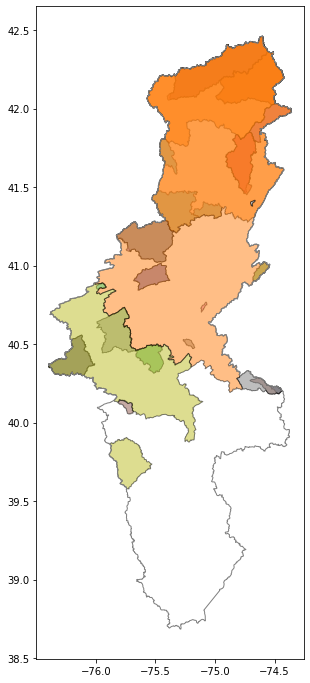

In [6]:
# Visualize
ax =geo_nodes.plot(column = 'node', edgecolor = 'black', alpha = 0.5, figsize=(8,12))
drb_boundary.plot(ax=ax, color = 'none', edgecolor = '0.5')